In [38]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchinfo import summary

from utils import *
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import csv



In [39]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [40]:
# torch.cuda.empty_cache()
import gc
model = None
gc.collect()
torch.cuda.empty_cache()

In [41]:
source_path = "../Combined_data"
training_path = "../Combined_train_test/train"
testing_path = "../Combined_train_test/test"
train_test_ratio = 0.7
# split(source_path, training_path, testing_path, train_test_ratio) 

In [43]:
len(train_dataset) + len(test_dataset)

61486

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


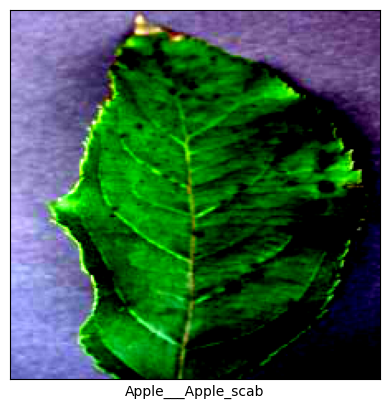

In [5]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [7]:
batch_size = 64
learning_rate = 0.05
train_val_ratio = 0.8
num_epochs = 10
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)
num_classes = len(classes)


Length of Train Data : 34430
Length of Validation Data : 8608


In [7]:
# Defining all models
efficient_model = load_efficient_net().to(device)
efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)


mobile_model = load_mobile_net().to(device)
mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)


resnet_model = load_resnet().to(device)
resnet_model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True).to(device)


# vgg_model = load_vgg().to(device)
# vgg_model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True).to(device)

loss_fn = nn.CrossEntropyLoss()


## Training EfficientNet-B0

In [8]:
# efficientNet B0 model
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=learning_rate)
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5357 | train_acc: 0.3447 | train_f1: 0.3447 | val_loss: 3.7259 | val_acc: 0.2704 | val_f1: 0.2704 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 1.4477 | train_acc: 0.5966 | train_f1: 0.5966 | val_loss: 6.1740 | val_acc: 0.2292 | val_f1: 0.2292 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 1.0651 | train_acc: 0.7001 | train_f1: 0.7001 | val_loss: 1.3598 | val_acc: 0.6575 | val_f1: 0.6575 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.8980 | train_acc: 0.7538 | train_f1: 0.7538 | val_loss: 1.4471 | val_acc: 0.6599 | val_f1: 0.6599 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.8083 | train_acc: 0.7874 | train_f1: 0.7874 | val_loss: 0.4861 | val_acc: 0.8626 | val_f1: 0.8626 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.7740 | train_acc: 0.8037 | tra

In [9]:
path_name = "../Models/compared_csv/efficient_model("+str(batch_size)+", "+str(learning_rate)+").csv"
write_to_csv(path_name, efficient_results, num_epochs)

In [10]:
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.81      0.81      0.81       300
                            Apple___Black_rot       0.97      0.88      0.92       300
                     Apple___Cedar_apple_rust       0.95      0.99      0.97       300
                              Apple___healthy       0.90      0.89      0.90       494
                    Background_without_leaves       0.93      0.97      0.95       343
                          Blueberry___healthy       1.00      0.81      0.89       451
                      Cherry___Powdery_mildew       0.97      0.79      0.87       316
                             Cherry___healthy       0.87      0.98      0.92       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.34      0.50       300
                           Corn___Common_rust       0.94      1.00      0.97       358
                  Corn___Northern_Leaf_Bli

In [11]:
# Saving efficient model
torch.save(efficient_model, "../Models/compared_models/efficient_model("+str(batch_size)+", "+str(learning_rate)+").pt")

## Training MobileNet-V2

In [12]:
# MobileNet V2 model
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=learning_rate)
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)

# torch.save(mobile_model, "../Models/combined_mobile_model_1.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7567 | train_acc: 0.2593 | train_f1: 0.2593 | val_loss: 2.3500 | val_acc: 0.3297 | val_f1: 0.3297 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 1.8542 | train_acc: 0.4551 | train_f1: 0.4551 | val_loss: 1.8589 | val_acc: 0.4552 | val_f1: 0.4552 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 1.3473 | train_acc: 0.5866 | train_f1: 0.5866 | val_loss: 2.4317 | val_acc: 0.3674 | val_f1: 0.3674 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 1.1136 | train_acc: 0.6503 | train_f1: 0.6503 | val_loss: 1.7587 | val_acc: 0.5349 | val_f1: 0.5349 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 1.0030 | train_acc: 0.6853 | train_f1: 0.6853 | val_loss: 1.4952 | val_acc: 0.5745 | val_f1: 0.5745 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.9110 | train_acc: 0.7112 | tra

In [13]:
mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.73      0.50      0.60       300
                            Apple___Black_rot       0.43      0.94      0.59       300
                     Apple___Cedar_apple_rust       0.63      0.87      0.73       300
                              Apple___healthy       0.38      0.83      0.52       494
                    Background_without_leaves       0.90      0.84      0.87       343
                          Blueberry___healthy       0.48      0.96      0.64       451
                      Cherry___Powdery_mildew       0.74      0.60      0.66       316
                             Cherry___healthy       0.92      0.23      0.36       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.70      0.36      0.47       300
                           Corn___Common_rust       0.93      0.98      0.96       358
                  Corn___Northern_Leaf_Bli

In [14]:
path_name = "../Models/compared_csv/mobile_model("+str(batch_size)+", "+str(learning_rate)+").csv"
write_to_csv(path_name, mobile_results, num_epochs)

In [15]:
torch.save(mobile_model, "../Models/compared_models/mobile_model("+str(batch_size)+", "+str(learning_rate)+").pt")

## Training ResNet-18

In [16]:
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)
resnet_results = train(model=resnet_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4636 | train_acc: 0.3571 | train_f1: 0.3571 | val_loss: 1.5563 | val_acc: 0.5208 | val_f1: 0.5208 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 1.0455 | train_acc: 0.6828 | train_f1: 0.6828 | val_loss: 0.9275 | val_acc: 0.7106 | val_f1: 0.7106 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.6916 | train_acc: 0.7824 | train_f1: 0.7824 | val_loss: 0.6572 | val_acc: 0.7928 | val_f1: 0.7928 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.5476 | train_acc: 0.8247 | train_f1: 0.8247 | val_loss: 0.5318 | val_acc: 0.8319 | val_f1: 0.8319 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.4480 | train_acc: 0.8578 | train_f1: 0.8578 | val_loss: 0.4306 | val_acc: 0.8642 | val_f1: 0.8642 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.3948 | train_acc: 0.8727 | tra

In [17]:
resnet_report = test_run(resnet_model, test_dl, device, batch_size, classes)
print(resnet_report)

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.71      0.82       300
                            Apple___Black_rot       0.86      0.98      0.92       300
                     Apple___Cedar_apple_rust       0.96      0.99      0.98       300
                              Apple___healthy       0.87      0.90      0.88       494
                    Background_without_leaves       0.97      0.85      0.90       343
                          Blueberry___healthy       0.93      0.96      0.94       451
                      Cherry___Powdery_mildew       0.95      0.94      0.94       316
                             Cherry___healthy       0.91      0.99      0.95       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.84      0.77      0.80       300
                           Corn___Common_rust       0.95      0.99      0.97       358
                  Corn___Northern_Leaf_Bli

In [18]:
path_name = "../Models/compared_csv/resnet_model("+str(batch_size)+", "+str(learning_rate)+").csv"
write_to_csv(path_name, resnet_results, num_epochs)

In [19]:
torch.save(resnet_model, "../Models/compared_models/resnet_model("+str(batch_size)+", "+str(learning_rate)+").pt")

## Training VGG

In [12]:
path = "../Models/compared_models/efficient_model(128, 0.001).pt"
model = load_model(path)

print(test_run(model, test_dl, device, classes))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      1.00      0.99       300
                            Apple___Black_rot       0.99      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       1.00      0.98      0.99       494
                    Background_without_leaves       1.00      1.00      1.00       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      1.00      1.00       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.95      0.96       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [29]:
summary(model,(128,3,224,224))


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [128, 39]                 --
├─Sequential: 1-1                                       [128, 1280, 7, 7]         --
│    └─Conv2dNormActivation: 2-1                        [128, 32, 112, 112]       --
│    │    └─Conv2d: 3-1                                 [128, 32, 112, 112]       864
│    │    └─BatchNorm2d: 3-2                            [128, 32, 112, 112]       64
│    │    └─SiLU: 3-3                                   [128, 32, 112, 112]       --
│    └─Sequential: 2-2                                  [128, 16, 112, 112]       --
│    │    └─MBConv: 3-4                                 [128, 16, 112, 112]       1,448
│    └─Sequential: 2-3                                  [128, 24, 56, 56]         --
│    │    └─MBConv: 3-5                                 [128, 24, 56, 56]         6,004
│    │    └─MBConv: 3-6                              

In [33]:
path = "../Models/compared_models/efficient_model(64, 0.001).pt"
model = load_model(path)
summary(model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

In [37]:
path = "../Models/compared_models/mobile_model(64, 0.001).pt"
model = load_model(path)
summary(model)

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

In [35]:
path = "../Models/compared_models/resnet_model(64, 0.001).pt"
model = load_model(path)
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

### Finish